In [31]:
# importing all neccessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import os

sns.set_style('whitegrid')


In [32]:
# Now, load the data from the unzipped CSV files
train_df = pd.read_csv('kaggle_dataset/train.csv')
test_df = pd.read_csv('kaggle_dataset/test.csv')

# Set the 'Id' column as the index for consistency
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

print("Data loaded successfully:")
train_df.head()

Training data shape: (1460, 80)
Testing data shape: (1459, 79)
Data loaded successfully:


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


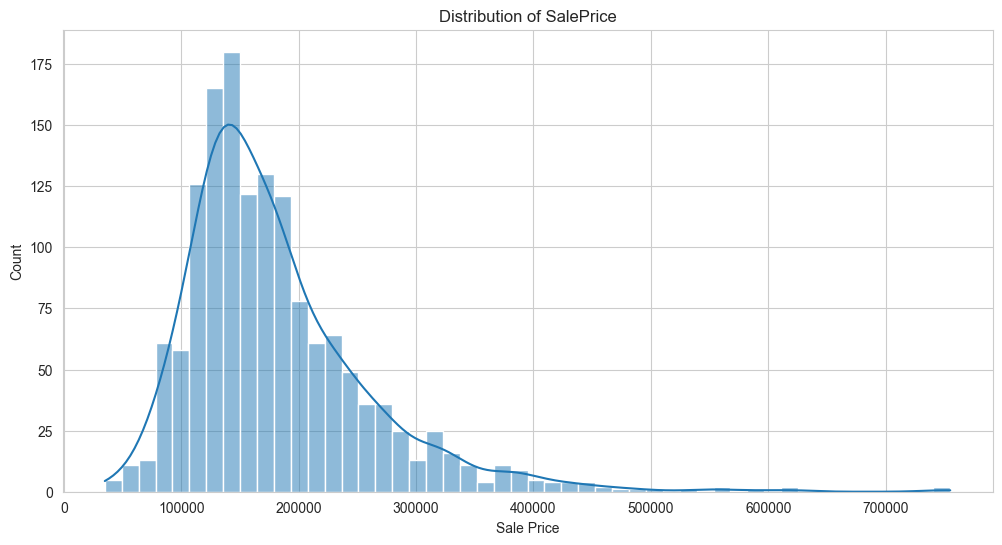

Skewness of SalePrice: 1.8828757597682129


In [33]:
plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins = 50)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')
plt.show()

print(f"Skewness of SalePrice: {train_df['SalePrice'].skew()}")

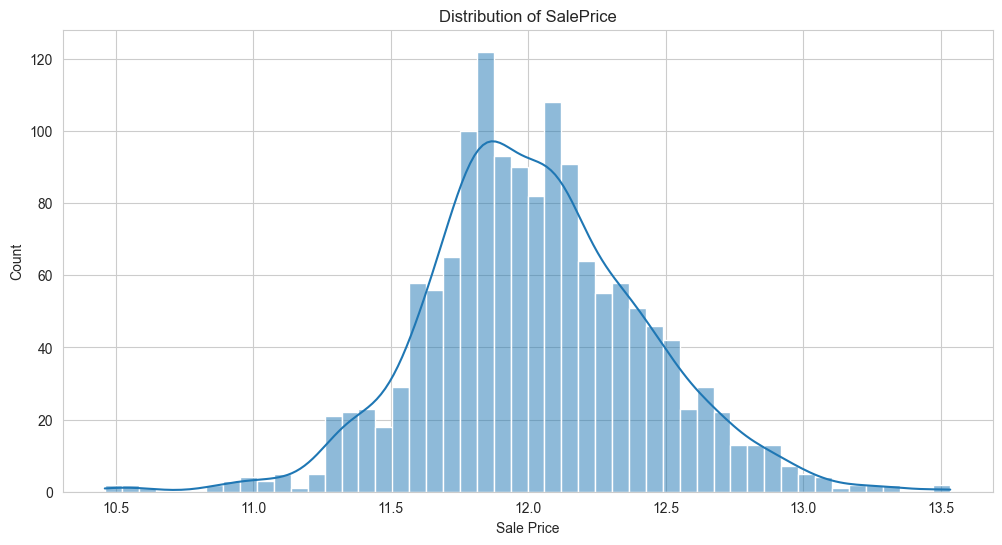

Skewness of SalePrice: 0.12134661989685333


In [34]:
# converting the target variable into normal distribution
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins = 50)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')
plt.show()

print(f"Skewness of SalePrice: {train_df['SalePrice'].skew()}")

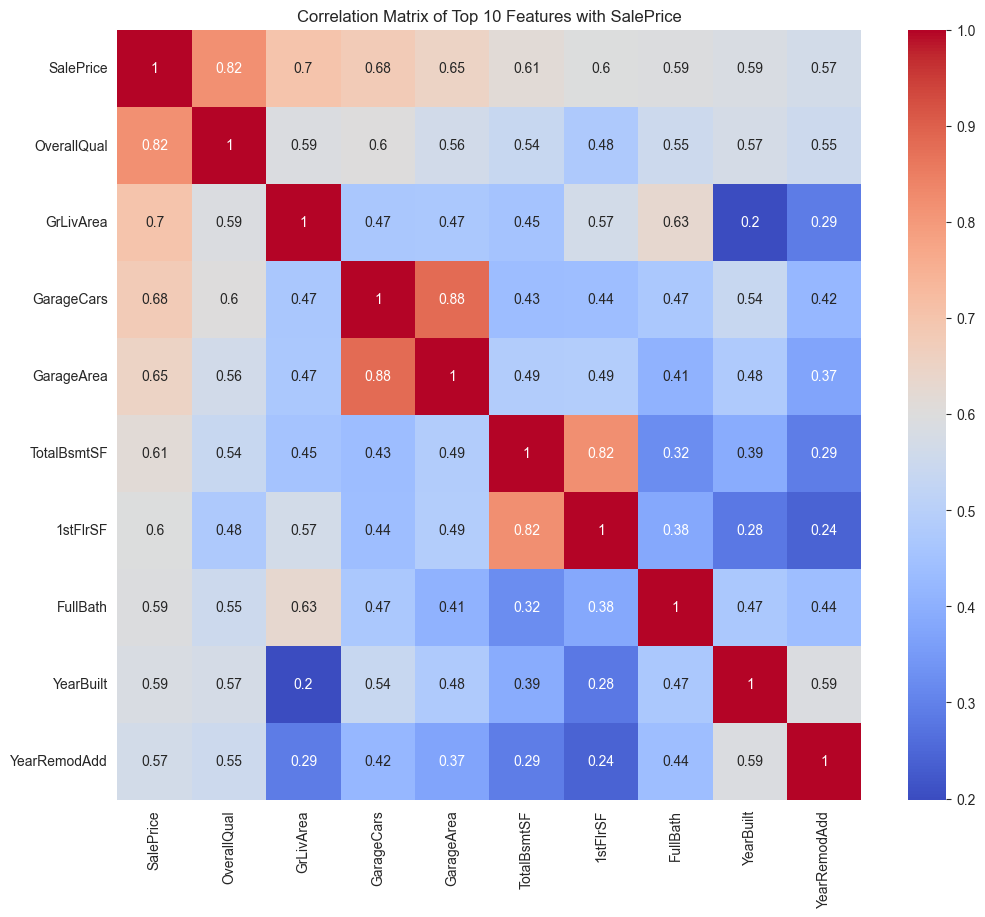

In [35]:
corrmat = train_df.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
top_corr_matrix = train_df[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

In [36]:
# combining both the dataset
df = pd.concat((train_df.loc[:,:"SaleCondition"],test_df.loc[:,:'SaleCondition']))

print(f"Combined data shape: {df.shape}")

Combined data shape: (2919, 79)


In [41]:
# handling missing values 
missing_data = df.isna().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data>0]
missing_data

GarageYrBlt    159
dtype: int64

In [38]:
df['Utilities'].value_counts()

Utilities
AllPub    2916
NoSeWa       1
Name: count, dtype: int64

In [39]:
numerical_cols_to_impute_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in numerical_cols_to_impute_zero:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Impute categorical features with 'None' (for features where NA means 'no') or mode (for features where NA means missing data)
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in df.columns: # Check if column exists after one-hot encoding
        df[col] = df[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in df.columns: # Check if column exists after one-hot encoding
        df[col] = df[col].fillna(df[col].mode()[0])
df[numerical_cols_to_impute_zero].isna().sum()

MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
GarageCars      0
GarageArea      0
BsmtFullBath    0
BsmtHalfBath    0
dtype: int64

In [47]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))
if 'GarageYrBlt' in df.columns:
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

In [48]:
df['GarageYrBlt'].value_counts()

GarageYrBlt
0.0       159
2005.0    142
2006.0    115
2007.0    115
2004.0     99
         ... 
1896.0      1
1895.0      1
2207.0      1
1943.0      1
1919.0      1
Name: count, Length: 104, dtype: int64

In [51]:
# Feature engineering
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

df['TotalBath'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                         df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

df['Age'] = df['YrSold'] - df['YearBuilt']


In [ ]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,TotalBath,Age
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,None,None,0,2,2008,WD,Normal,2566.0,3.5,5
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,None,None,0,5,2007,WD,Normal,2524.0,2.5,31
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,None,None,0,9,2008,WD,Normal,2706.0,3.5,7
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,None,None,0,2,2006,WD,Abnorml,2473.0,2.0,91
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,None,None,0,12,2008,WD,Normal,3343.0,3.5,8


In [60]:
# Convert any remaining object columns to category type for one-hot encoding
print(f"Data shape before encoding: {df.shape}")
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"Data shape after encoding: {df.shape}")

Data shape before encoding: (2919, 82)
Data shape after encoding: (2919, 262)


In [61]:
# separate X and y
X = df[:len(train_df)]
y = train_df['SalePrice'] # SalePrice was already log-transformed and is only in train_df
X_test_final = df[len(train_df):]

# Split the training data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
255,20,70.0,8400,5,6,1957,1957,0.0,922.0,0.0,...,False,False,False,False,True,False,False,False,True,False
1067,60,59.0,7837,6,7,1993,1994,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
639,30,67.0,8777,5,7,1910,1950,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
800,50,60.0,7200,5,7,1937,1950,252.0,569.0,0.0,...,False,False,False,False,True,False,False,False,True,False
381,50,50.0,5000,5,6,1924,1950,0.0,218.0,0.0,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,20,78.0,9317,6,5,2006,2006,0.0,24.0,0.0,...,False,False,False,False,True,False,False,False,True,False
1131,50,65.0,7804,4,3,1928,1950,0.0,622.0,0.0,...,False,False,False,False,True,False,False,False,True,False
1295,20,60.0,8172,5,7,1955,1990,0.0,167.0,0.0,...,False,False,False,False,True,False,False,False,True,False


In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_final_scaled = scaler.transform(X_test_final)

In [67]:
# linear regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

In [68]:
y_pred_lr

array([11.94136732, 12.73981795, 11.51734525, 12.01487948, 12.64926257,
       11.28125177, 12.42367424, 11.89852165, 11.22643455, 11.86994258,
       11.88608842, 11.64392657, 11.23230401, 12.26138536, 12.07110195,
       11.80087308, 12.14706831, 11.78972384, 11.58284822, 12.2693948 ,
       11.92793845, 12.22406554, 12.07011723, 11.82560994, 12.19616524,
       11.89526696, 12.15166979, 11.60271912, 12.10684603, 12.1969508 ,
       12.08657634, 12.53744901, 12.30214298, 11.66556937, 12.45474616,
       11.93105985, 11.89189847, 12.19935819, 12.68351764, 11.58686028,
       11.80931906, 12.29662339, 11.60207364, 12.82646513, 11.75787557,
       11.74918942, 11.57708431, 11.81620749, 13.04562787, 11.8267837 ,
       11.7062313 , 12.24629524, 11.5574877 , 12.6258775 , 12.0258037 ,
       12.38911243, 12.22142841, 11.95688407, 11.78095167, 11.50236687,
       11.30197603, 11.9977707 , 12.64750084, 12.40696689, 12.60854943,
       12.19663563, 11.60748068, 12.68077664, 11.77433401, 12.06

In [69]:
# XGBoost
xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=1000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)

# XGBoost can handle NaNs, but since we've cleaned the data, we can use the scaled data as well if preferred.
# However, XGBoost generally doesn't require scaling. We'll use the unscaled data as it's a tree-based model.
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_test)

In [70]:
y_pred_xgb

array([11.879156 , 12.7500925, 11.595143 , 11.913677 , 12.758328 ,
       11.257912 , 12.339215 , 11.880939 , 11.181985 , 11.835368 ,
       11.914844 , 11.652088 , 11.601943 , 12.219792 , 12.079586 ,
       11.796339 , 12.15045  , 11.791124 , 11.652535 , 12.279766 ,
       11.98962  , 12.341758 , 12.02584  , 11.794717 , 12.188702 ,
       11.984673 , 12.166126 , 11.586217 , 12.096347 , 12.167188 ,
       11.729817 , 12.48274  , 12.226758 , 11.667491 , 12.53001  ,
       11.903845 , 11.808561 , 12.216319 , 12.689865 , 11.640691 ,
       11.710644 , 12.402964 , 11.676519 , 12.807462 , 11.765766 ,
       11.746519 , 11.658153 , 11.731433 , 13.012444 , 11.820557 ,
       11.707636 , 12.18188  , 11.558677 , 12.637202 , 11.924963 ,
       12.426675 , 12.201476 , 11.968927 , 11.812485 , 11.513413 ,
       11.13121  , 12.064229 , 12.62083  , 12.540033 , 12.625292 ,
       12.204764 , 11.647044 , 12.737384 , 11.533363 , 12.014604 ,
       11.699927 , 11.721689 , 11.656786 , 11.357646 , 13.1040

In [72]:
# evaluating the model
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")

evaluate_model(y_test, y_pred_lr, "Linear Regression") # Commenting out Linear Regression evaluation as it failed
evaluate_model(y_test, y_pred_xgb, "XGBoost")

--- Linear Regression Performance ---
RMSE: 0.1734
MAE:  0.0960
R-squared: 0.8389

--- XGBoost Performance ---
RMSE: 0.1344
MAE:  0.0864
R-squared: 0.9032



In [73]:
# Make predictions on the final test set using the best model (XGBoost)
# Use the unscaled test data for XGBoost prediction
final_predictions_log = xgbr.predict(X_test_final)

# IMPORTANT: We must reverse the log transformation to get the predictions back on the original price scale
final_predictions = np.expm1(final_predictions_log)

# Create the submission DataFrame
submission = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})

# Save to csv
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
submission.head()

Submission file 'submission.csv' created successfully.


,Id,SalePrice
0,1461,123225.789062
1,1462,163591.781250
2,1463,190166.703125
3,1464,194260.031250
4,1465,182331.875000


In [ ]:
# submitted